In [99]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pyfits

%matplotlib inline

starPosCCD = [1048+256,1024]

def populateSkyArray(imageData, area):
    sky = np.copy(imageData[:,area[0]:area[1]])
    return sky

def populateObjectArray(imageData, areas):
    nCols = 0
    for area in areas:
        nCols += area[1]-area[0]
#    print 'nCols = ',nCols
    obsCols = np.zeros(shape=(imageData.shape[0],nCols), dtype=type(imageData[0,0]))
    nCols = 0
    for area in areas:
#        print 'imageData[1000,',area[0],':',area[1],'] = ',imageData[1000,area[0]:area[1]]
        obsCols[:,nCols:nCols+area[1]-area[0]] = np.copy(imageData[:,area[0]:area[1]])
        nCols += area[1]-area[0]
    return obsCols

# --- fit y = a*x + b
# --- return value w: w[0] = a, w[1] = b
def linReg(x,y):
    A = np.array([ x, np.ones(len(x))])
#    print 'linReg: x.shape = ',x.shape,', A.shape = ',A.shape,', y.shape = ',y.shape
    w = []
    for iy in range(y.shape[0]):
        w.append(np.linalg.lstsq(A.T,y[iy,:])[0])
#        print 'linReg: iy = ',iy,': w[',iy,'] = ',w[iy]
    return w

# axis: 0 (columns) or 1 (rows)
# width: odd number
def boxCarMedianSmooth(imageData, axis, width):
    newDataArray = np.zeros(shape=imageData.shape, dtype=type(imageData[0,0]))
    if axis == 0:
        for iRow in range(imageData.shape[0]):
            for iCol in range(imageData.shape[1]):
                if iCol < int(width/2.0):
                    iColStart = 0
                    iColEnd = iCol+int(width/2.0)+1
                elif iCol > imageData.shape[1]-int(width/2.0)-1:
                    iColStart = iCol - int(width/2.0)
                    iColEnd = imageData.shape[1]
                else:
                    iColStart = iCol - int(width/2.0)
                    iColEnd = iCol + int(width/2.0) + 1
                newDataArray[iRow,iCol] = np.median(imageData[iRow,iColStart:iColEnd])
#                print 'iRow = ',iRow,', iCol = ',iCol,': iColStart = ',iColStart,', iColEnd = ',iColEnd,': imageData[iRow,iColStart:iColEnd] = ',imageData[iRow,iColStart:iColEnd],': median = ',newDataArray[iRow,iCol]
    elif axis == 1:
        for iCol in range(imageData.shape[1]):
            for iRow in range(imageData.shape[0]):
                if iRow < int(width/2.0):
                    iRowStart = 0
                    iRowEnd = iRow+int(width/2.0)+1
                elif iRow > imageData.shape[0]-int(width/2.0)-1:
                    iRowStart = iRow - int(width/2.0)
                    iRowEnd = imageData.shape[1]
                else:
                    iRowStart = iRow - int(width/2.0)
                    iRowEnd = iRow + int(width/2.0) + 1
                newDataArray[iRow,iCol] = np.median(imageData[iRowStart:iRowEnd,iCol])
#                print 'iCol = ',iCol,', iRow = ',iRow,': iRowStart = ',iRowStart,', iRowEnd = ',iRowEnd,': imageData[iRowStart:iRowEnd,iCol] = ',imageData[iRowStart:iRowEnd,iCol],': median = ',newDataArray[iRow,iCol]
    else:
        print 'ERROR: axis(=',axis,') out of bounds [0,1]'
    return newDataArray

def subtractSky(imageData,skyLeftArea,skyRightArea):
    newImageData = np.ndarray(imageData.shape, dtype=type(imageData[0,0]))
    skyData = np.ndarray(imageData.shape, dtype=type(imageData[0,0]))
    xSky = np.concatenate([np.arange(skyLeftArea[0],skyLeftArea[1],1.0),np.arange(skyRightArea[0],skyRightArea[1],1.0)])
#    print 'subtractSky: xSky = ',xSky
    ySky = np.concatenate([populateSkyArray(imageData, skyLeftArea), populateSkyArray(imageData, skyRightArea)],axis=1)
#    print 'subtractSky ySky = ',len(ySky),': ',ySky
    skyParams = linReg(xSky,ySky)
#    print 'type(skyParams) = ',type(skyParams)
#    print 'subtractSky: imageData.shape = ',imageData.shape,', newImageData.shape = ',newImageData.shape,', xSky.shape = ',xSky.shape,', len(skyParams) = ',len(skyParams),', len(skyParams[0]) = ',len(skyParams[0])
    xObs = np.arange(0,imageData.shape[1],1.0,dtype=type(imageData[0,0]))
#    print 'subtractSky: xObs = ',xObs.shape,': ',xObs
    for iRow in range(imageData.shape[0]):
#        print 'subtractSky: imageData[',iRow,',:] = ',imageData[iRow,:],', newImageData[',iRow,',:].shape = ',newImageData[iRow,:].shape,', skyParams[',iRow,'] = ',len(skyParams[iRow]),': ',skyParams[iRow]
        skyData[iRow,:] = (skyParams[iRow][0] * xObs) + skyParams[iRow][1]
#        print 'subtractSky: skyData[',iRow,',:] = ',skyData[iRow,:]
        newImageData[iRow,:] = imageData[iRow,:] - skyData[iRow,:]
#        print 'subtractSky: newImageData[',iRow,',:] = ',newImageData[iRow,:]
    return [newImageData,skyData]

#def subtractSky(obsAreas,obsData,skyLeftArea,skyLeft,skyRightArea,skyRight):
#    newObsData = np.ndarray(obsData.shape, dtype=type(obsData[0,0]))
##    xSkyLeft = np.arange(skyLeftArea[0],skyLeftArea[1],1.0)
##    xSkyRight = np.arange(skyRightArea[0],skyRightArea[1],1.0)
#    xSky = np.concatenate([np.arange(skyLeftArea[0],skyLeftArea[1],1.0),np.arange(skyRightArea[0],skyRightArea[1],1.0)])
#    print 'subtractSky: xSky = ',xSky
#    nCols = 0
#    for area in obsAreas:
#        nCols += area[1]-area[0]
#    print 'subtractSky: nCols = ',nCols
#
#    xObs = np.ndarray(nCols, dtype=type(obsData[0,0]))
#    nCols = 0
#    for area in obsAreas:
#        xObs[nCols:nCols+area[1]-area[0]] = np.arange(area[0],area[1],1.0)
#        print 'subtractSky: area = ',area,': nCols = ',nCols,': xObs[',nCols,':',nCols+area[1]-area[0],'] = ',xObs[nCols:nCols+area[1]-area[0]]
#        nCols += area[1]-area[0]
#    print 'subtractSky: nCols = ',nCols
#    ySky = np.concatenate([skyLeft, skyRight],axis=1)
#    print 'subtractSky = ',len(ySky),': ',ySky
#    skyParams = linReg(xSky,ySky)
#    print 'type(skyParams) = ',type(skyParams)
#    print 'subtractSky: obsData.shape = ',obsData.shape,', newObsData.shape = ',newObsData.shape,', xObs.shape = ',xObs.shape,', len(skyParams) = ',len(skyParams),', len(skyParams[0]) = ',len(skyParams[0])
#    for iRow in range(obsData.shape[0]):
#        print 'subtractSky: obsData.shape = ',obsData.shape,', newObsData.shape = ',newObsData.shape,', obsData[',iRow,',:].shape = ',obsData[iRow,:].shape,', xObs.shape = ',xObs.shape,', len(skyParams) = ',len(skyParams)
#        newObsData[iRow,:] = obsData[iRow,:] - ((skyParams[iRow][1] * xObs) + skyParams[iRow][0])
#        print 'subtractSky: newObsData[',iRow,',:] = ',newObsData[iRow,:]
#    STOP
#    return newObsData

def getWavelength(header):
    nPix = int(header['NAXIS2'])
    crPix = int(header['CRPIX2'])
    crVal = float(header['CRVAL2'])
    cDelt = float(header['CDELT2'])
    lam = np.arange(crVal, crVal + (nPix*cDelt), cDelt, dtype=np.float32)
#    print 'getWavelength: lam = ',len(lam),': ',lam
    return lam

def markAreas(imageData, skyAreaLeft, skyAreaRight, objectAreas):
    maxImageData = np.amax(imageData)
    imageData[:,skyAreaLeft[0]] = 0.0
    imageData[:,skyAreaLeft[1]] = 0.0
    imageData[:,skyAreaRight[0]] = 0.0
    imageData[:,skyAreaRight[1]] = 0.0
    for area in objectAreas:
        imageData[:,area[0]] = maxImageData
        imageData[:,area[1]] = maxImageData

tab = [{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn19', 'SkyLeft':[1094,1166], 'SkyRight':[1474,1588], 'ObjectAreas':[[1200,1228],[1249,1306],[1321,1340],[1358,1450]]},#looks good
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ194645', 'SkyLeft':[835,960], 'SkyRight':[1570,1760], 'ObjectAreas':[[1262,1330],[1157,1240]]},#very wide, find sky from other imeage nearby
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn45', 'SkyLeft':[1104,1228], 'SkyRight':[1320,1435], 'ObjectAreas':[[1238,1296]]},#okay, small
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'OName': 'DSHJ205811', 'SkyLeft':[1094,1257], 'SkyRight':[1325,1469], 'ObjectAreas':[[1263,1286]]},#okay, small
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'OName': 'DSHJ221013', 'SkyLeft':[680,780], 'SkyRight':[1626,1704], 'ObjectAreas':[[1090,1292],[1334,1380],[1404,1506],[1538,1554]]},#okay
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ194745', 'SkyLeft':[1092,1276], 'SkyRight':[1544,1756], 'ObjectAreas':[[1300,1396]]},#hmmm, run that and try with sky from other image
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'OName': 'Ou3', 'SkyLeft':[836,1028], 'SkyRight':[1536,1608], 'ObjectAreas':[[1133,1227],[1238,1306],[1316,1387],[1402,1496]]},#looks good, line at 5004
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn24', 'SkyLeft':[700,850], 'SkyRight':[1700,1812], 'ObjectAreas':[[916,1038],[1090,1180],[1198,1306],[1320,1556],[1566,1700]]},#looks good, line at 5004
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'OName': 'LDu1', 'SkyLeft':[440,570], 'SkyRight':[1837,1918], 'ObjectAreas':[[1090,1350],[1374,1569]]},#looks good, line at 5004 and 6582
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0010/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ193617', 'SkyLeft':[1231,1288], 'SkyRight':[1423,1479], 'ObjectAreas':[[1293,1308],[1316,1331]]},#looks good, pretty compact
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0011/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ194728', 'SkyLeft':[1090,1185], 'SkyRight':[1444,1555], 'ObjectAreas':[[1248,1368]]},#looks good, lines at 6716,...
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ194301', 'SkyLeft':[1139,1248], 'SkyRight':[1382,1513], 'ObjectAreas':[[1272,1325]]},#looks good, pretty compact, lines at 6585, 6562
{'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0012a/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ194301', 'SkyLeft':[1090,1222], 'SkyRight':[1357,1475], 'ObjectAreas':[[1284,1348]]},#looks good, pretty compact, lines at 6585, 6562
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'OName': 'PNG124.1-01.9', 'SkyLeft':[1090,1177], 'SkyRight':[1376,1449], 'ObjectAreas':[[1299,1350]]},#looks good, lines at 4859 and 6716
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ014238+600947', 'SkyLeft':[682,816], 'SkyRight':[1930,2013], 'ObjectAreas':[[864,953],[968,1038],[1091,1126],[1138,1303],[1318,1424],[1440,1720],[1759,1902]]},#looks good, lines at 6584
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ031058.8+624755', 'SkyLeft':[170,324], 'SkyRight':[1961,2024], 'ObjectAreas':[[363,457],[478,542],[559,576],[594,726],[743,786],[820,855],[872,897],[910,1038],[1090,1273],[1328,1760],[1777,1850],[1867,1909],[1918,1950]]},#looks good at 4957 and 6579 - with central compact area (?)
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0003a/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ031058.8+624755', 'SkyLeft':[170,324], 'SkyRight':[1961,2024], 'ObjectAreas':[[363,457],[478,542],[559,576],[594,726],[743,786],[820,855],[872,897],[910,1038],[1090,1273],[1328,1431],[1504,1756],[1777,1850],[1867,1909],[1918,1950]]},#looks good at 4957 and 6579 - without central compact area (?)
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXj040721.5+512422', 'SkyLeft':[231,522], 'SkyRight':[1842,2010], 'ObjectAreas':[[1197,1303],[1320,1450]]},#looks good, lines at 4959, 5004, 6580, 6716
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ051152.2+302751', 'SkyLeft':[167,380], 'SkyRight':[1872,2025], 'ObjectAreas':[[701,1035],[1124,1154],[1171,1300],[1325,1555],[1607,1880]]},#Halpha region?
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ053650.8+245616', 'SkyLeft':[300,556], 'SkyRight':[1778,1923], 'ObjectAreas':[[1201,1304],[1320,1474]]},#faint lines around 6716
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ055242.8+262116', 'SkyLeft':[1090,1248], 'SkyRight':[1675,1957], 'ObjectAreas':[[1265,1304],[1317,1466]]},#looks good, compact, 4959, 5008, 6563
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0013/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ185322.1+083018', 'SkyLeft':[622,808], 'SkyRight':[1771,1971], 'ObjectAreas':[[1491,1537]]},#shell visible at 5005
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0020/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ191306.1+025248', 'SkyLeft':[423,468], 'SkyRight':[1836,1878], 'ObjectAreas':[[846,870],[882,977],[985,1002],[1011,1038],[1090,1119],[1132,1183],[1196,1223],[1245,1304],[1346,1390],[1519,1534],[1565,1626],[1635,1696],[1714,1746],[1758,1806]]},#clear shell at 6583
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026/gtc_object_av_wl_flt_cal.fits', 'OName': 'SNR060707', 'SkyLeft':[325,513], 'SkyRight':[1936,2021], 'ObjectAreas':[[888,958],[1101,1152],[1180,1210],[1245,1299],[1309,1350],[1368,1399],[1425,1478],[1491,1560]]},#lines at 6561, 6584, without extended regions near the center
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0026a/gtc_object_av_wl_flt_cal.fits', 'OName': 'SNR060707', 'SkyLeft':[325,513], 'SkyRight':[1936,2021], 'ObjectAreas':[[888,958],[1101,1299],[1309,1350],[1368,1399],[1425,1478],[1491,1560]]},#lines at 6561, 6584, without extended regions near the center
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0027/gtc_object_av_wl_flt_cal.fits', 'OName': 'SNR060715', 'SkyLeft':[517,800], 'SkyRight':[1718,2004], 'ObjectAreas':[[1256,1302],[1320,1388]]},#ok, some lines at 6563, 6717
{'FName': 'IPHAS_GTC_DATA/DATA3_2017B/GTC8-17BMEX/OB0028/gtc_object_av_wl_flt_cal.fits', 'OName': 'SNR060930', 'SkyLeft':[744,935], 'SkyRight':[1788,1927], 'ObjectAreas':[[1126,1242],[1258,1348],[1408,1555]]},#possible line at 6566
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'OName': 'KK26', 'SkyLeft':[680,920], 'SkyRight':[1730,2014], 'ObjectAreas':[[1112,1283],[1305,1559]]},#very nice blobs
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn34', 'SkyLeft':[800,940], 'SkyRight':[1468,1565], 'ObjectAreas':[[1163,1300],[1320,1360],[1394,1443]]},#ok, lines at 4861, 4960, 5006
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'OName': 'CR1', 'SkyLeft':[368,684], 'SkyRight':[1926,2025], 'ObjectAreas':[[1090,1341],[1358,1458],[1470,1530],[1537,1625]]},#ok, lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn11', 'SkyLeft':[1122,1194], 'SkyRight':[1427,1532], 'ObjectAreas':[[1278,1303],[1317,1340]]},#okay, compact, lines 6547, 6562, 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'OName': 'HaWe3', 'SkyLeft':[643,1017], 'SkyRight':[1489,1628], 'ObjectAreas':[[1229,1301],[1320,1391]]},#okay, lines at 4958, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0006/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn48', 'SkyLeft':[770,874], 'SkyRight':[1442,1570], 'ObjectAreas':[[1216,1301],[1316,1332],[1345,1389],[1401,1420]]},#okay lines at 4861, 4958, 5006
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn58', 'SkyLeft':[1090,1190], 'SkyRight':[1526,1700], 'ObjectAreas':[[1195,1304],[1324,1430]]},#okay, lines at 4955, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'OName': 'Ou2', 'SkyLeft':[852,925], 'SkyRight':[1528,1604], 'ObjectAreas':[[1133,1367],[1397,1507]]},#okay, lines at 4955, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0009/gtc_object_av_wl_flt_cal.fits', 'OName': 'Abell68', 'SkyLeft':[1090,1168], 'SkyRight':[1432,1477], 'ObjectAreas':[[1188,1305],[1317,1368],[1379,1397]]},#okay, lines at 4684, 4861, 4958, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0010/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn24', 'SkyLeft':[747,939], 'SkyRight':[1893,2020], 'ObjectAreas':[[945,998],[1013,1036],[1090,1241],[1254,1303],[1338,1400],[1453,1558],[1581,1763]]},#hmmm, possible line at 6585
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0011/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ190333_Green_Slit', 'SkyLeft':[612,702], 'SkyRight':[1823,1855], 'ObjectAreas':[[1090,1125],[1164,1212],[1238,1252],[1267,1295],[1307,1353],[1367,1444],[1495,1516],[1530,1556],[1600,1650],[1665,1700]]},#faint line at 5005, 6565, 6585, 6829, 6862
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0012/gtc_object_av_wl_flt_cal.fits', 'OName': 'K1-6', 'SkyLeft':[314,732], 'SkyRight':[1680,1957], 'ObjectAreas':[[957,1036],[1090,1132],[1148,1243],[1388,1582]]},#okay, lines at 4861, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0013/gtc_object_av_wl_flt_cal.fits', 'OName': 'LDu1', 'SkyLeft':[407,717], 'SkyRight':[1847,2020], 'ObjectAreas':[[643,752],[762,807],[819,880],[1090,1166],[1182,1226],[1238,1304],[1315,1350],[1395,1452],[1465,1480],[1492,1550],[1561,1573],[1588,1673]]},
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0015/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ195627', 'SkyLeft':[1090,1178], 'SkyRight':[1438,1505], 'ObjectAreas':[[1259,1337]]},#Hmmm, faint line at 6563
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0016/gtc_object_av_wl_flt_cal.fits', 'OName': 'IRAS20084', 'SkyLeft':[1128,1206], 'SkyRight':[1681,1780], 'ObjectAreas':[[1290,1299],[1322,1329]]},#nothing really but HASH shows compact cloud in 432
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0017/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ201058', 'SkyLeft':[637,914], 'SkyRight':[1671,1781], 'ObjectAreas':[[1213,1268],[1286,1340]]},#faint lines at 6565 and 6585
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0018/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn36', 'SkyLeft':[366,547], 'SkyRight':[1884,1940], 'ObjectAreas':[[1188,1300],[1345,1361],[1398,1420]]},#ok lines at 4956, 5005
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0019/gtc_object_av_wl_flt_cal.fits', 'OName': 'We2-260', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]},#
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0020/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ225420', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]},#
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0023/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn25', 'SkyLeft':[445,489], 'SkyRight':[1614,1658], 'ObjectAreas':[[1171,1212],[1265,1283],[1331,1345],[1398,1433]]},#lines at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0024/gtc_object_av_wl_flt_cal.fits', 'OName': 'We1-10', 'SkyLeft':[369,450], 'SkyRight':[1922,2023], 'ObjectAreas':[[752,839],[860,978],[994,1020],[1090,1195],[1206,1295],[1325,1402],[1417,1472],[1504,1554],[1568,1618],[1633,1658],[1675,1845]]},# line at 4959
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0025/gtc_object_av_wl_flt_cal.fits', 'OName': 'KTC1', 'SkyLeft':[1090,1190], 'SkyRight':[1390,1505], 'ObjectAreas':[[1244,1301],[1321,1375]]},#easy, lines at 4957 and 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0026/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn30', 'SkyLeft':[1090,1260], 'SkyRight':[1388,1506], 'ObjectAreas':[[1301,1329],[1338,1364]]},#easy, lines at 4859, 4957, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0027/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn31', 'SkyLeft':[496,900], 'SkyRight':[1611,1720], 'ObjectAreas':[[1167,1222],[1238,1301],[1316,1495]]},#okay, lines at 4959, 5005
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0028/gtc_object_av_wl_flt_cal.fits', 'OName': '', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]},#
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0029/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ230323', 'SkyLeft':[802,1031], 'SkyRight':[1696,1866], 'ObjectAreas':[[1150,1222],[1248,1397]]},#faint line at 6561
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0030/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ010133', 'SkyLeft':[520,716], 'SkyRight':[1685,1794], 'ObjectAreas':[[1100,1242],[1259,1375]]},#line at 4859
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0031/gtc_object_av_wl_flt_cal.fits', 'OName': 'Ju1', 'SkyLeft':[185,390], 'SkyRight':[1819,1983], 'ObjectAreas':[[790,880],[901,974],[1004,1035],[1090,1201],[1222,1238],[1261,1301],[1344,1414],[1432,1495],[1515,1543],[1600,1632],[1728,1814]]},#line at 1960
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0032/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn51', 'SkyLeft':[391,688], 'SkyRight':[1847,1978], 'ObjectAreas':[[1200,1302],[1317,1448]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033/gtc_object_av_wl_flt_cal.fits', 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[1131,1164]]},#difficult, possible line at 6581, without extended objects
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033a/gtc_object_av_wl_flt_cal.fits', 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[801,891],[1131,1164]]},#difficult, possible line at 6581, with left extended object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0033b/gtc_object_av_wl_flt_cal.fits', 'OName': 'FsMv1', 'SkyLeft':[695,817], 'SkyRight':[1650,1809], 'ObjectAreas':[[1131,1164],[1205,1306]]},#difficult, possible line at 6581, with left extended object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0034/gtc_object_av_wl_flt_cal.fits', 'OName': 'KnJ0240', 'SkyLeft':[1142,1244], 'SkyRight':[1395,1530], 'ObjectAreas':[[1284,1303],[1327,1351]]},#compact, lines at 4988, 5090, 5137
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0035/gtc_object_av_wl_flt_cal.fits', 'OName': 'KnJ1857', 'SkyLeft':[810,913], 'SkyRight':[1874,2014], 'ObjectAreas':[[1221,1293],[1335,1374]]},#can't see lines just a possibly extended (compact) object in the center
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0036/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ214032', 'SkyLeft':[1090,1250], 'SkyRight':[1552,1661], 'ObjectAreas':[[1312,1356]]},#lines at 4961 and 5005, no central star visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0037/gtc_object_av_wl_flt_cal.fits', 'OName': 'DSHJ192315', 'SkyLeft':[1185,1214], 'SkyRight':[1687,1748], 'ObjectAreas':[[1277,1299],[1318,1329]]},#lines at 4961 and 5005, pretty compact object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0038/gtc_object_av_wl_flt_cal.fits', 'OName': 'DSHJ204858', 'SkyLeft':[908,965], 'SkyRight':[1745,1890], 'ObjectAreas':[[1090,1284],[1430,1556]]},#lines at 4860, 4958, 5005, central object gets wider in some wavelength ranges
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0039/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn20', 'SkyLeft':[878,964], 'SkyRight':[1570,1606], 'ObjectAreas':[[1296,1332]]},#lines at 6563 and 6582, only on right side of a star (no central star visible?)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0040/gtc_object_av_wl_flt_cal.fits', 'OName': 'DSHJ195813', 'SkyLeft':[708,799], 'SkyRight':[1603,1655], 'ObjectAreas':[[1214,1257],[1288,1300],[1320,1354],[1383,1394]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0042/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn59', 'SkyLeft':[1090,1185], 'SkyRight':[1412,1511], 'ObjectAreas':[[1285,1305],[1320,1340]]},#compact, lines at 4861, 4959, 5005
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0043/gtc_object_av_wl_flt_cal.fits', 'OName': '', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]},#
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044/gtc_object_av_wl_flt_cal.fits', 'OName': 'Alves1', 'SkyLeft':[286,446], 'SkyRight':[1752,1939], 'ObjectAreas':[[1170,1297],[1324,1471]]},#nothing, without central object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0044a/gtc_object_av_wl_flt_cal.fits', 'OName': 'Alves1', 'SkyLeft':[286,446], 'SkyRight':[1752,1939], 'ObjectAreas':[[1170,1471]]},#nothing, with central object
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0045/gtc_object_av_wl_flt_cal.fits', 'OName': 'DSHJ205943', 'SkyLeft':[1090,1143], 'SkyRight':[1348,1403], 'ObjectAreas':[[1291,1306],[1317,1329]]},#compact, lines at 4858, 4956, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0046/gtc_object_av_wl_flt_cal.fits', 'OName': 'Ou5', 'SkyLeft':[1123,1257], 'SkyRight':[1440,1512], 'ObjectAreas':[[1274,1323],[1342,1385]]},#lines at 4861, 4959, 5005, 5873
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0048/gtc_object_av_wl_flt_cal.fits', 'OName': 'DSHJ062355', 'SkyLeft':[811,1028], 'SkyRight':[1677,1790], 'ObjectAreas':[[1090,1139],[1154,1213],[1225,1278],[1301,1334],[1361,1434],[1462,1608]]},#lines at 4959, 5005
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0049/gtc_object_av_wl_flt_cal.fits', 'OName': '', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]},#
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0052/gtc_object_av_wl_flt_cal.fits', 'OName': 'Ou2', 'SkyLeft':[831,909], 'SkyRight':[1800,1984], 'ObjectAreas':[[1128,1263],[1277,1300],[1318,1327],[1338,1344],[1381,1483]]},#lines at 4684, 4957, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0055/gtc_object_av_wl_flt_cal.fits', 'OName': 'We2-260', 'SkyLeft':[512,772], 'SkyRight':[1677,1777], 'ObjectAreas':[[871,1038],[1090,1400],[1426,1560],[1567,1657]]},#line at 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0056/gtc_object_av_wl_flt_cal.fits', 'OName': 'Si1-2', 'SkyLeft':[714,954], 'SkyRight':[1524,1578], 'ObjectAreas':[[1167,1304],[1335,1369],[1386,1406],[1419,1436]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0057/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ023538', 'SkyLeft':[719,956], 'SkyRight':[1784,1987], 'ObjectAreas':[[1247,1321],[1370,1449]]},#faint continuum both sides of the central faint object (not included)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0062/gtc_object_av_wl_flt_cal.fits', 'OName': 'DSHJ202907', 'SkyLeft':[926,1034], 'SkyRight':[1600,1847], 'ObjectAreas':[[1227,1274]]},#lines at 4860, 4958, 5005, bright star offset to center (not included)
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0065/gtc_object_av_wl_flt_cal.fits', 'OName': 'Pa30', 'SkyLeft':[839,935], 'SkyRight':[1740,1823], 'ObjectAreas':[[1323,1344],[1389,1400]]},#possible doublet at 6697, 6711 and redshifted at 6737, 6750
#{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0067/gtc_object_av_wl_flt_cal.fits', 'OName': '', 'SkyLeft':[612,0], 'SkyRight':[0,0], 'ObjectAreas':[[0,0],[0,0]]},#
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0068/gtc_object_av_wl_flt_cal.fits', 'OName': 'HaWe15', 'SkyLeft':[394,486], 'SkyRight':[1964,2025], 'ObjectAreas':[[711,766],[796,916],[936,997],[1020,1038],[1131,1208],[1365,1565],[1707,1765],[1799,1822]]},#extended object with lines at 4957, 5005,...
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0069/gtc_object_av_wl_flt_cal.fits', 'OName': 'We2-5', 'SkyLeft':[710,772], 'SkyRight':[1925,1973], 'ObjectAreas':[[879,1037],[1090,1125],[1143,1233],[1251,1297],[1397,1446],[1514,1711],[1742,1786],[1846,1907]]},#lines at 6546, 6562, 6582
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0070/gtc_object_av_wl_flt_cal.fits', 'OName': 'KLSS2-8', 'SkyLeft':[702,1017], 'SkyRight':[1560,1740], 'ObjectAreas':[[1136,1299],[1325,1409],[1437,1479]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0073/gtc_object_av_wl_flt_cal.fits', 'OName': 'PM1-305', 'SkyLeft':[1149,1211], 'SkyRight':[1625,1663], 'ObjectAreas':[[1283,1303],[1322,1359]]},#lines at 4860, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0079/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn33', 'SkyLeft':[778,891], 'SkyRight':[1791,1879], 'ObjectAreas':[[1305,1351],[1376,1418]]},#lines at 4861, 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2016A/GTC4-16AMEX/OB0080/gtc_object_av_wl_flt_cal.fits', 'OName': 'KKR62', 'SkyLeft':[860,962], 'SkyRight':[1577,1769], 'ObjectAreas':[[1195,1295],[1318,1378]]},#line at 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0001/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ191306.1+025248', 'SkyLeft':[429,475], 'SkyRight':[1780,1837], 'ObjectAreas':[[929,972],[992,1038],[1090,1116],[1157,1196],[1234,1288],[1322,1348],[1376,1403],[1471,1526],[1640,1665],[1688,1714]]},#lines at 4861, 5005, 5200
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0003/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ190543.8+064413', 'SkyLeft':[717,921], 'SkyRight':[1567,1756], 'ObjectAreas':[[1267,1338]]},#lines at 6550, 6563, 6583, no central object visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0004/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ191058.9+040350', 'SkyLeft':[840,920], 'SkyRight':[1608,1674], 'ObjectAreas':[[1277,1368]]},#lines at 4957, 5005, no central object visible
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0005/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ191104.8+060845', 'SkyLeft':[786,1019], 'SkyRight':[1411,1512], 'ObjectAreas':[[1277,1325],[1340,1362]]},#lines at 4959, 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0007/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ191707.3+020010', 'SkyLeft':[670,708], 'SkyRight':[1951,2005], 'ObjectAreas':[[1230,1271],[1300,1317],[1351,1385],[1420,1453]]},#lines at 4860 and 5005
{'FName': 'IPHAS_GTC_DATA/DATA4_2018A/GTC11-18AMEX/OB0008/gtc_object_av_wl_flt_cal.fits', 'OName': 'IPHASXJ191918.8+171148', 'SkyLeft':[1090,1186], 'SkyRight':[1451,1557], 'ObjectAreas':[[1251,1300],[1321,1331],[1340,1395]]}]#lines at 6548, 6561, 6583

i=1
for obs in tab:
    image_file = os.path.join('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/',obs['FName'])
    hdulist = pyfits.open(image_file)
#    print 'type(hdulist) = ',type(hdulist)
    header = hdulist[0].header
    obs['OName'] = header['OBJECT']
    print obs
    if True:
        wavelength = getWavelength(header)
        image_data = fits.getdata(image_file)
#        print 'type(image_data) = ',type(image_data)
#        print 'type(image_data[1000,1000]) = ',type(image_data[1000,1000])
#        print 'len(image_data) = ',len(image_data)
#        print 'image_data.shape = ',image_data.shape
#        print 'image_data[1551,',obs['ObjectAreas'][0][0]+1,'] = ',image_data[1551,obs['ObjectAreas'][0][0]+1]
        imageMinusSky, imageSky = subtractSky(image_data,obs['SkyLeft'],obs['SkyRight'])
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]

        obsCols = populateObjectArray(imageMinusSky,obs['ObjectAreas'])
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsCols[1000,0] = %.3e' % (obsCols[1000,0])
#        print 'sum(obsCols[1551,:]) = ',np.sum(obsCols[1551,:])
        
        obsColsSmoothed = boxCarMedianSmooth(obsCols, 0, 5)
#        print 'sum(obsColsSmoothed[1551,:]) = ',np.sum(obsColsSmoothed[1551,:])
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
#        print 'imageMinusSky[1551,',obs['ObjectAreas'][0][0]+1,':',obs['ObjectAreas'][0][0]+5,'] = ',imageMinusSky[1551,obs['ObjectAreas'][0][0]+1:obs['ObjectAreas'][0][0]+5]
#        print 'obsCols[1551,1:5] = ',obsCols[1551,1:5]
#        print 'obsColsSmoothed[1551,1:5] = ',obsColsSmoothed[1551,1:5]
        
        spectrum = np.ndarray(skyLeft.shape[0], dtype=np.float32)
        for iRow in range(spectrum.shape[0]):
            spectrum[iRow] = np.sum(obsColsSmoothed[iRow,:])
#            print 'spectrum[',iRow,'] = ',spectrum[iRow]
        
        plt.plot(wavelength,spectrum)
        plt.xlabel('wavelength [A]')
        plt.ylabel('calibrated flux [erg/cm2/s/A]')
        plt.show()
        
        # --- mark sky and object areas in original image
        markAreas(image_data, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])
        markAreas(imageMinusSky, obs['SkyLeft'], obs['SkyRight'], obs['ObjectAreas'])

        hdulist[0].data = obsCols
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsCols.fits', clobber=True)

        hdulist[0].data = obsColsSmoothed
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_obsColsSmoothed.fits', clobber=True)

        hdulist[0].data = image_data
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_areasMarked.fits', clobber=True)

        hdulist[0].data = imageSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_sky.fits', clobber=True)

        hdulist[0].data = imageMinusSky
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsCols[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_not_smoothed.fits', clobber=True)
        
        hdulist[0].data = imageMinusSky
        nCols = 0
        for area in obs['ObjectAreas']:
            hdulist[0].data[:,area[0]:area[1]] = obsColsSmoothed[:,nCols:nCols+area[1]-area[0]]
            nCols += area[1]-area[0]
        hdulist.writeto(image_file[0:image_file.rfind('.')]+'_mSky_obs_smoothed.fits', clobber=True)
        
        # --- write spectrum
        with open(image_file[0:image_file.rfind('.')]+'_spec.dat','w') as f:
            for i in range(len(wavelength)):
                f.write('%.5e %.5e\n' % (wavelength[i], spectrum[i]))
#        STOP
#    plt.imshow(image_data, cmap='gray')
#    plt.colorbar()
#    i+=1
#    if i == 3:
#        STOP
#print tab

type(hdulist) =  <class 'pyfits.hdu.hdulist.HDUList'>
{'ObjectAreas': [[1200, 1228], [1249, 1306], [1321, 1340], [1358, 1450]], 'SkyLeft': [1094, 1166], 'SkyRight': [1474, 1588], 'FName': 'IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/gtc_object_av_wl_flt_cal.fits', 'OName': 'Kn19'}
getWavelength: lam =  2051 :  [3347.6306 3349.7505 3351.8704 ... 7689.131  7691.251  7693.37  ]
linReg: x.shape =  (186,) , A.shape =  (2, 186) , y.shape =  (2051, 186)
linReg: iy =  0 : w[ 0 ] =  [0. 0.]
linReg: iy =  1 : w[ 1 ] =  [0. 0.]
linReg: iy =  2 : w[ 2 ] =  [0. 0.]
linReg: iy =  3 : w[ 3 ] =  [0. 0.]
linReg: iy =  4 : w[ 4 ] =  [0. 0.]
linReg: iy =  5 : w[ 5 ] =  [0. 0.]
linReg: iy =  6 : w[ 6 ] =  [0. 0.]
linReg: iy =  7 : w[ 7 ] =  [0. 0.]
linReg: iy =  8 : w[ 8 ] =  [0. 0.]
linReg: iy =  9 : w[ 9 ] =  [0. 0.]
linReg: iy =  10 : w[ 10 ] =  [0. 0.]
linReg: iy =  11 : w[ 11 ] =  [0. 0.]
linReg: iy =  12 : w[ 12 ] =  [0. 0.]
linReg: iy =  13 : w[ 13 ] =  [0. 0.]
linReg: iy =  14 : w[ 14 ] =  [0. 

/Users/azuri/anaconda/envs/python2env/lib/python2.7/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


 58 : w[ 58 ] =  [0. 0.]
linReg: iy =  59 : w[ 59 ] =  [0. 0.]
linReg: iy =  60 : w[ 60 ] =  [0. 0.]
linReg: iy =  61 : w[ 61 ] =  [0. 0.]
linReg: iy =  62 : w[ 62 ] =  [0. 0.]
linReg: iy =  63 : w[ 63 ] =  [0. 0.]
linReg: iy =  64 : w[ 64 ] =  [0. 0.]
linReg: iy =  65 : w[ 65 ] =  [0. 0.]
linReg: iy =  66 : w[ 66 ] =  [0. 0.]
linReg: iy =  67 : w[ 67 ] =  [0. 0.]
linReg: iy =  68 : w[ 68 ] =  [0. 0.]
linReg: iy =  69 : w[ 69 ] =  [0. 0.]
linReg: iy =  70 : w[ 70 ] =  [0. 0.]
linReg: iy =  71 : w[ 71 ] =  [0. 0.]
linReg: iy =  72 : w[ 72 ] =  [0. 0.]
linReg: iy =  73 : w[ 73 ] =  [0. 0.]
linReg: iy =  74 : w[ 74 ] =  [0. 0.]
linReg: iy =  75 : w[ 75 ] =  [0. 0.]
linReg: iy =  76 : w[ 76 ] =  [0. 0.]
linReg: iy =  77 : w[ 77 ] =  [0. 0.]
linReg: iy =  78 : w[ 78 ] =  [0. 0.]
linReg: iy =  79 : w[ 79 ] =  [0. 0.]
linReg: iy =  80 : w[ 80 ] =  [0. 0.]
linReg: iy =  81 : w[ 81 ] =  [0. 0.]
linReg: iy =  82 : w[ 82 ] =  [0. 0.]
linReg: iy =  83 : w[ 83 ] =  [0. 0.]
linReg: iy =  84 : w[ 84 

linReg: iy =  335 : w[ 335 ] =  [-7.15814136e-22  3.03849954e-17]
linReg: iy =  336 : w[ 336 ] =  [-1.08870647e-21  3.10279937e-17]
linReg: iy =  337 : w[ 337 ] =  [-9.0251501e-22  3.0291422e-17]
linReg: iy =  338 : w[ 338 ] =  [-5.85462475e-22  2.91884602e-17]
linReg: iy =  339 : w[ 339 ] =  [-8.91282603e-22  3.02173395e-17]
linReg: iy =  340 : w[ 340 ] =  [-3.22516816e-22  3.03804415e-17]
linReg: iy =  341 : w[ 341 ] =  [-4.78582539e-22  3.07013695e-17]
linReg: iy =  342 : w[ 342 ] =  [-6.91312301e-22  3.06208964e-17]
linReg: iy =  343 : w[ 343 ] =  [-8.54309845e-22  3.04668191e-17]
linReg: iy =  344 : w[ 344 ] =  [-1.02220742e-21  3.05269612e-17]
linReg: iy =  345 : w[ 345 ] =  [-1.54806036e-21  3.16775666e-17]
linReg: iy =  346 : w[ 346 ] =  [-1.1578574e-21  3.2034123e-17]
linReg: iy =  347 : w[ 347 ] =  [-9.30223292e-22  3.20342568e-17]
linReg: iy =  348 : w[ 348 ] =  [-1.12687598e-21  3.24432554e-17]
linReg: iy =  349 : w[ 349 ] =  [-7.96194835e-22  3.27768629e-17]
linReg: iy =  

linReg: iy =  467 : w[ 467 ] =  [1.18408281e-21 2.26222198e-17]
linReg: iy =  468 : w[ 468 ] =  [1.35653123e-21 2.05425629e-17]
linReg: iy =  469 : w[ 469 ] =  [1.33621562e-21 2.07106636e-17]
linReg: iy =  470 : w[ 470 ] =  [8.96058323e-22 2.31417741e-17]
linReg: iy =  471 : w[ 471 ] =  [9.69452901e-22 2.48796115e-17]
linReg: iy =  472 : w[ 472 ] =  [1.12338486e-21 2.53943107e-17]
linReg: iy =  473 : w[ 473 ] =  [1.14393509e-21 2.48528019e-17]
linReg: iy =  474 : w[ 474 ] =  [8.83931872e-22 2.45743900e-17]
linReg: iy =  475 : w[ 475 ] =  [9.24424498e-22 2.48308175e-17]
linReg: iy =  476 : w[ 476 ] =  [1.24530035e-21 2.55093881e-17]
linReg: iy =  477 : w[ 477 ] =  [9.28635051e-22 2.67351048e-17]
linReg: iy =  478 : w[ 478 ] =  [5.14460646e-22 2.76142040e-17]
linReg: iy =  479 : w[ 479 ] =  [5.71675704e-22 2.77912360e-17]
linReg: iy =  480 : w[ 480 ] =  [9.77808104e-22 2.71502692e-17]
linReg: iy =  481 : w[ 481 ] =  [6.99236754e-22 2.69453998e-17]
linReg: iy =  482 : w[ 482 ] =  [6.93150

linReg: iy =  598 : w[ 598 ] =  [1.28243177e-21 2.67992560e-17]
linReg: iy =  599 : w[ 599 ] =  [1.51221706e-21 2.64785964e-17]
linReg: iy =  600 : w[ 600 ] =  [1.21116461e-21 2.69862051e-17]
linReg: iy =  601 : w[ 601 ] =  [8.24697310e-22 2.75962434e-17]
linReg: iy =  602 : w[ 602 ] =  [9.72007547e-22 2.74328819e-17]
linReg: iy =  603 : w[ 603 ] =  [8.32376575e-22 2.76609851e-17]
linReg: iy =  604 : w[ 604 ] =  [7.30185473e-22 2.77253741e-17]
linReg: iy =  605 : w[ 605 ] =  [7.45069664e-22 2.76411387e-17]
linReg: iy =  606 : w[ 606 ] =  [1.05880667e-21 2.70746331e-17]
linReg: iy =  607 : w[ 607 ] =  [1.14129720e-21 2.66649117e-17]
linReg: iy =  608 : w[ 608 ] =  [7.80288416e-22 2.67786040e-17]
linReg: iy =  609 : w[ 609 ] =  [7.28817908e-22 2.67660388e-17]
linReg: iy =  610 : w[ 610 ] =  [9.48327156e-22 2.65339836e-17]
linReg: iy =  611 : w[ 611 ] =  [1.08694769e-21 2.62403890e-17]
linReg: iy =  612 : w[ 612 ] =  [1.03463005e-21 2.57567684e-17]
linReg: iy =  613 : w[ 613 ] =  [9.38721

linReg: iy =  731 : w[ 731 ] =  [1.20431459e-21 2.41163279e-17]
linReg: iy =  732 : w[ 732 ] =  [1.07477941e-21 2.41249842e-17]
linReg: iy =  733 : w[ 733 ] =  [6.73772684e-22 2.44164541e-17]
linReg: iy =  734 : w[ 734 ] =  [8.88517491e-22 2.40204868e-17]
linReg: iy =  735 : w[ 735 ] =  [1.02326107e-21 2.37370951e-17]
linReg: iy =  736 : w[ 736 ] =  [8.86014743e-22 2.35975180e-17]
linReg: iy =  737 : w[ 737 ] =  [7.28130227e-22 2.34678632e-17]
linReg: iy =  738 : w[ 738 ] =  [5.50283654e-22 2.37324944e-17]
linReg: iy =  739 : w[ 739 ] =  [5.55406816e-22 2.38913640e-17]
linReg: iy =  740 : w[ 740 ] =  [7.49255629e-22 2.31175855e-17]
linReg: iy =  741 : w[ 741 ] =  [4.98657733e-22 2.24080517e-17]
linReg: iy =  742 : w[ 742 ] =  [3.26165422e-22 2.20438282e-17]
linReg: iy =  743 : w[ 743 ] =  [5.05280097e-22 2.21849694e-17]
linReg: iy =  744 : w[ 744 ] =  [6.48050512e-22 2.29395143e-17]
linReg: iy =  745 : w[ 745 ] =  [5.63313756e-22 2.38844969e-17]
linReg: iy =  746 : w[ 746 ] =  [5.56662

linReg: iy =  870 : w[ 870 ] =  [-4.43122977e-22  2.18405911e-17]
linReg: iy =  871 : w[ 871 ] =  [-6.23391247e-22  2.20330020e-17]
linReg: iy =  872 : w[ 872 ] =  [-4.45171479e-22  2.21092936e-17]
linReg: iy =  873 : w[ 873 ] =  [-2.17185415e-22  2.23651389e-17]
linReg: iy =  874 : w[ 874 ] =  [-3.45086693e-22  2.28554589e-17]
linReg: iy =  875 : w[ 875 ] =  [-3.25118475e-22  2.25904844e-17]
linReg: iy =  876 : w[ 876 ] =  [-3.84905382e-22  2.20954682e-17]
linReg: iy =  877 : w[ 877 ] =  [-5.39735676e-22  2.18979305e-17]
linReg: iy =  878 : w[ 878 ] =  [-5.34076137e-22  2.20244964e-17]
linReg: iy =  879 : w[ 879 ] =  [-4.28466515e-22  2.23704442e-17]
linReg: iy =  880 : w[ 880 ] =  [-1.50349487e-22  2.22303772e-17]
linReg: iy =  881 : w[ 881 ] =  [4.24158842e-23 2.18585002e-17]
linReg: iy =  882 : w[ 882 ] =  [-9.73653119e-23  2.20704335e-17]
linReg: iy =  883 : w[ 883 ] =  [-2.98277676e-22  2.26480446e-17]
linReg: iy =  884 : w[ 884 ] =  [-3.09387864e-22  2.28080152e-17]
linReg: iy =

linReg: iy =  1004 : w[ 1004 ] =  [-8.26669115e-22  2.17903294e-17]
linReg: iy =  1005 : w[ 1005 ] =  [-7.01478480e-22  2.15038637e-17]
linReg: iy =  1006 : w[ 1006 ] =  [-6.68449683e-22  2.16650445e-17]
linReg: iy =  1007 : w[ 1007 ] =  [-8.52555084e-22  2.22607820e-17]
linReg: iy =  1008 : w[ 1008 ] =  [-8.63608861e-22  2.24875072e-17]
linReg: iy =  1009 : w[ 1009 ] =  [-7.31664578e-22  2.24029332e-17]
linReg: iy =  1010 : w[ 1010 ] =  [-7.43973149e-22  2.24139916e-17]
linReg: iy =  1011 : w[ 1011 ] =  [-8.19076407e-22  2.25086700e-17]
linReg: iy =  1012 : w[ 1012 ] =  [-8.32973006e-22  2.25634987e-17]
linReg: iy =  1013 : w[ 1013 ] =  [-8.62294249e-22  2.26039513e-17]
linReg: iy =  1014 : w[ 1014 ] =  [-9.90126532e-22  2.27918054e-17]
linReg: iy =  1015 : w[ 1015 ] =  [-1.11802779e-21  2.29543569e-17]
linReg: iy =  1016 : w[ 1016 ] =  [-1.02412359e-21  2.27487620e-17]
linReg: iy =  1017 : w[ 1017 ] =  [-8.68122539e-22  2.24313457e-17]
linReg: iy =  1018 : w[ 1018 ] =  [-7.68045872e-

linReg: iy =  1132 : w[ 1132 ] =  [-1.76267897e-21  2.30711200e-17]
linReg: iy =  1133 : w[ 1133 ] =  [-1.68827788e-21  2.27922015e-17]
linReg: iy =  1134 : w[ 1134 ] =  [-1.7101645e-21  2.2616400e-17]
linReg: iy =  1135 : w[ 1135 ] =  [-1.69074871e-21  2.25023941e-17]
linReg: iy =  1136 : w[ 1136 ] =  [-1.63015609e-21  2.24782995e-17]
linReg: iy =  1137 : w[ 1137 ] =  [-1.65798803e-21  2.26162273e-17]
linReg: iy =  1138 : w[ 1138 ] =  [-1.63506974e-21  2.25672273e-17]
linReg: iy =  1139 : w[ 1139 ] =  [-1.72114178e-21  2.26324631e-17]
linReg: iy =  1140 : w[ 1140 ] =  [-1.72902433e-21  2.27743013e-17]
linReg: iy =  1141 : w[ 1141 ] =  [-1.73090334e-21  2.30378273e-17]
linReg: iy =  1142 : w[ 1142 ] =  [-1.77306916e-21  2.32183828e-17]
linReg: iy =  1143 : w[ 1143 ] =  [-1.85416943e-21  2.32400973e-17]
linReg: iy =  1144 : w[ 1144 ] =  [-1.84043394e-21  2.30872187e-17]
linReg: iy =  1145 : w[ 1145 ] =  [-1.89449486e-21  2.31066142e-17]
linReg: iy =  1146 : w[ 1146 ] =  [-1.95658664e-21

linReg: iy =  1290 : w[ 1290 ] =  [2.91740434e-23 1.88340011e-17]
linReg: iy =  1291 : w[ 1291 ] =  [2.36541472e-23 1.88419902e-17]
linReg: iy =  1292 : w[ 1292 ] =  [6.61833867e-23 1.87674336e-17]
linReg: iy =  1293 : w[ 1293 ] =  [1.58469446e-22 1.86366912e-17]
linReg: iy =  1294 : w[ 1294 ] =  [1.00680916e-22 1.87192552e-17]
linReg: iy =  1295 : w[ 1295 ] =  [1.20630336e-22 1.87133928e-17]
linReg: iy =  1296 : w[ 1296 ] =  [2.90606128e-22 1.85808460e-17]
linReg: iy =  1297 : w[ 1297 ] =  [3.47870451e-22 1.85618809e-17]
linReg: iy =  1298 : w[ 1298 ] =  [3.13173416e-22 1.84638141e-17]
linReg: iy =  1299 : w[ 1299 ] =  [2.61142517e-22 1.83000436e-17]
linReg: iy =  1300 : w[ 1300 ] =  [3.02148662e-22 1.81607996e-17]
linReg: iy =  1301 : w[ 1301 ] =  [3.11033702e-22 1.82657073e-17]
linReg: iy =  1302 : w[ 1302 ] =  [2.34082627e-22 1.85933963e-17]
linReg: iy =  1303 : w[ 1303 ] =  [4.06614352e-22 1.84851438e-17]
linReg: iy =  1304 : w[ 1304 ] =  [4.58471704e-22 1.84549091e-17]
linReg: iy

linReg: iy =  1566 : w[ 1566 ] =  [3.10348637e-22 1.65470549e-17]
linReg: iy =  1567 : w[ 1567 ] =  [1.71567591e-22 1.67398498e-17]
linReg: iy =  1568 : w[ 1568 ] =  [2.37333979e-22 1.65696722e-17]
linReg: iy =  1569 : w[ 1569 ] =  [2.85951182e-22 1.63716512e-17]
linReg: iy =  1570 : w[ 1570 ] =  [4.01345910e-22 1.60563332e-17]
linReg: iy =  1571 : w[ 1571 ] =  [4.71739480e-22 1.58666621e-17]
linReg: iy =  1572 : w[ 1572 ] =  [3.36129604e-22 1.61000591e-17]
linReg: iy =  1573 : w[ 1573 ] =  [2.04914577e-22 1.63993623e-17]
linReg: iy =  1574 : w[ 1574 ] =  [2.16320616e-22 1.64698582e-17]
linReg: iy =  1575 : w[ 1575 ] =  [2.63331452e-22 1.64411990e-17]
linReg: iy =  1576 : w[ 1576 ] =  [2.67069277e-22 1.64314253e-17]
linReg: iy =  1577 : w[ 1577 ] =  [3.43632561e-22 1.62640514e-17]
linReg: iy =  1578 : w[ 1578 ] =  [4.92653004e-22 1.59977214e-17]
linReg: iy =  1579 : w[ 1579 ] =  [3.57881105e-22 1.61908127e-17]
linReg: iy =  1580 : w[ 1580 ] =  [2.03590690e-22 1.64395346e-17]
linReg: iy

linReg: iy =  1693 : w[ 1693 ] =  [-1.40005046e-22  1.60117095e-17]
linReg: iy =  1694 : w[ 1694 ] =  [-2.1543974e-22  1.6645921e-17]
linReg: iy =  1695 : w[ 1695 ] =  [3.3752376e-23 1.6267263e-17]
linReg: iy =  1696 : w[ 1696 ] =  [4.76906614e-22 1.54528423e-17]
linReg: iy =  1697 : w[ 1697 ] =  [4.11040277e-22 1.61406687e-17]
linReg: iy =  1698 : w[ 1698 ] =  [-2.36270866e-22  1.83957248e-17]
linReg: iy =  1699 : w[ 1699 ] =  [-6.14492170e-22  1.96657783e-17]
linReg: iy =  1700 : w[ 1700 ] =  [-2.63392525e-22  1.84946073e-17]
linReg: iy =  1701 : w[ 1701 ] =  [2.76592892e-22 1.61899975e-17]
linReg: iy =  1702 : w[ 1702 ] =  [3.97276246e-22 1.48650218e-17]
linReg: iy =  1703 : w[ 1703 ] =  [2.84318612e-22 1.46169802e-17]
linReg: iy =  1704 : w[ 1704 ] =  [1.17796299e-22 1.48037640e-17]
linReg: iy =  1705 : w[ 1705 ] =  [1.17108472e-22 1.48925035e-17]
linReg: iy =  1706 : w[ 1706 ] =  [2.05062011e-22 1.50343866e-17]
linReg: iy =  1707 : w[ 1707 ] =  [1.74609112e-22 1.55845942e-17]
linR

linReg: iy =  1815 : w[ 1815 ] =  [1.53504402e-22 1.21991755e-17]
linReg: iy =  1816 : w[ 1816 ] =  [1.40463072e-22 1.22477252e-17]
linReg: iy =  1817 : w[ 1817 ] =  [1.28692056e-22 1.21929670e-17]
linReg: iy =  1818 : w[ 1818 ] =  [1.92850680e-22 1.19652175e-17]
linReg: iy =  1819 : w[ 1819 ] =  [2.08960968e-22 1.19096445e-17]
linReg: iy =  1820 : w[ 1820 ] =  [2.14931885e-22 1.20578461e-17]
linReg: iy =  1821 : w[ 1821 ] =  [2.03160419e-22 1.23831697e-17]
linReg: iy =  1822 : w[ 1822 ] =  [8.85004563e-23 1.29359927e-17]
linReg: iy =  1823 : w[ 1823 ] =  [-8.30745037e-23  1.34910076e-17]
linReg: iy =  1824 : w[ 1824 ] =  [-3.70787009e-23  1.35574584e-17]
linReg: iy =  1825 : w[ 1825 ] =  [1.36475461e-22 1.33464715e-17]
linReg: iy =  1826 : w[ 1826 ] =  [2.37514880e-22 1.32414192e-17]
linReg: iy =  1827 : w[ 1827 ] =  [1.58034305e-22 1.34149599e-17]
linReg: iy =  1828 : w[ 1828 ] =  [1.76308246e-22 1.33996033e-17]
linReg: iy =  1829 : w[ 1829 ] =  [1.14608434e-22 1.34459675e-17]
linReg

KeyboardInterrupt: 

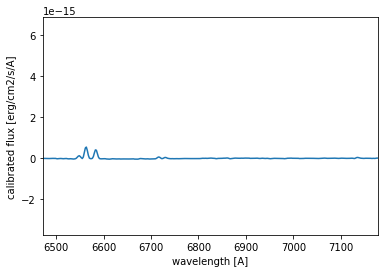

In [98]:
%matplotlib inline
wavelength = []
spectrum = []
with open('/Volumes/obiwan/azuri/spectra/IPHAS_GTC/IPHAS_GTC_DATA/DATA2_2017A/GTC12-17AMEX/OB0002/gtc_object_av_wl_flt_cal_spec.dat','r') as f:
    for lines in f:
        line = lines.split()
        wavelength.append(float(line[0]))
        spectrum.append(float(line[1]))
plt.plot(wavelength,spectrum)
plt.xlabel('wavelength [A]')
plt.ylabel('calibrated flux [erg/cm2/s/A]')
plt.xlim(6472.0, 7178.0)
plt.show()
